# 📊 Baseline Policy: (s,S) Theory

Understanding the classical inventory control policy.

**Goal**: Learn (s,S) policy before comparing with RL

In [1]:
import sys
sys.path.insert(0, '../..')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 4)

## Part 1: What is (s,S) Policy?

### The Rule:
```
IF inventory_position ≤ s:
    order (S - inventory_position) units
ELSE:
    don't order
```

### Parameters:
- **s** (lowercase): Reorder point - WHEN to order
- **S** (uppercase): Order-up-to level - HOW MUCH to order

### Key Formula:
**Inventory Position (IP)** = Net_Inventory + Outstanding_Orders

(Remember: net_inventory = on_hand - backorders)

In [2]:
from src.mdp import create_observation

# Policy parameters
s = 30  # Reorder point
S = 60  # Order-up-to level

print(f"Policy: (s={s}, S={S})")
print(f"\nRule: If IP ≤ {s}, order up to {S}")
print("\nExamples:")

# Example 1: High inventory position
obs1 = create_observation(50, 50, 0, 0)
ip1 = obs1.get_inventory_position(0)
print(f"\n1. Net_inv=50, Outstanding=0 → IP={ip1}")
if ip1 <= s:
    order = S - ip1
    print(f"   → ORDER {order} units (bring IP to {S})")
else:
    print(f"   → DON'T ORDER (IP > {s})")

# Example 2: Low inventory position
obs2 = create_observation(25, 50, 0, 0)
ip2 = obs2.get_inventory_position(0)
print(f"\n2. Net_inv=25, Outstanding=0 → IP={ip2}")
if ip2 <= s:
    order = S - ip2
    print(f"   → ORDER {order} units (bring IP to {S})")
else:
    print(f"   → DON'T ORDER (IP > {s})")

# Example 3: Stockout with order in-transit
obs3 = create_observation(-10, 50, 20, 0)  # Backorders but order coming!
ip3 = obs3.get_inventory_position(0)
print(f"\n3. Net_inv=-10 (backorders!), Outstanding=20 → IP={ip3}")
print(f"   Net_inv=-10 means {obs3.get_backorders(0)} backorders")
if ip3 <= s:
    order = S - ip3
    print(f"   → ORDER {order} units (bring IP to {S})")
else:
    print(f"   → DON'T ORDER (IP > {s})")

print("\n💡 IP accounts for both backorders AND in-transit orders!")

Policy: (s=30, S=60)

Rule: If IP ≤ 30, order up to 60

Examples:

1. Net_inv=50, Outstanding=0 → IP=50
   → DON'T ORDER (IP > 30)

2. Net_inv=25, Outstanding=0 → IP=25
   → ORDER 35 units (bring IP to 60)

3. Net_inv=-10 (backorders!), Outstanding=20 → IP=10
   Net_inv=-10 means 10 backorders
   → ORDER 50 units (bring IP to 60)

💡 IP accounts for both backorders AND in-transit orders!


## Part 2: Visualize (s,S) Decision Rule

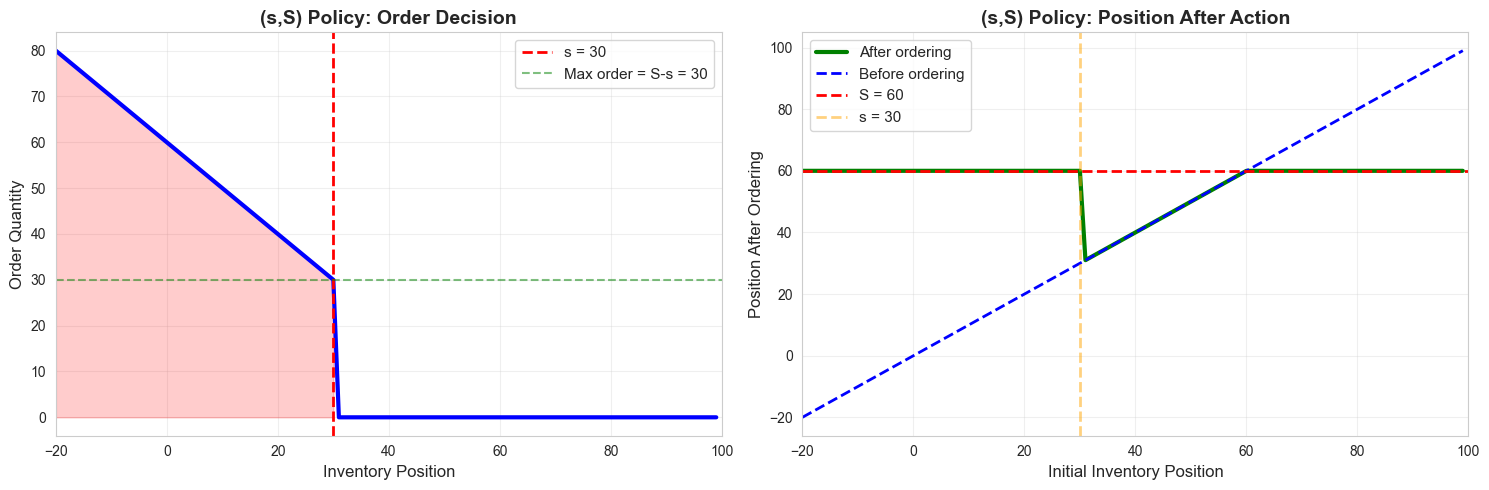


✓ Key observations:
   - Below s: Order to bring position to S
   - Above s: Don't order
   - Creates 'acceptable band' [31, 60]


In [3]:
# Simulate policy for different inventory positions
positions = np.arange(-20, 100, 1)
orders = []

for pos in positions:
    if pos <= s:
        orders.append(S - pos)
    else:
        orders.append(0)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Order quantity vs position
axes[0].plot(positions, orders, linewidth=3, color='blue')
axes[0].axvline(s, color='red', linestyle='--', linewidth=2, label=f's = {s}')
axes[0].axhline(S-s, color='green', linestyle='--', alpha=0.5, label=f'Max order = S-s = {S-s}')
axes[0].fill_between(positions, 0, orders, where=(positions <= s), alpha=0.2, color='red')
axes[0].set_xlabel('Inventory Position', fontsize=12)
axes[0].set_ylabel('Order Quantity', fontsize=12)
axes[0].set_title('(s,S) Policy: Order Decision', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim(-20, 100)

# Position after ordering
position_after = [min(pos + order, S) for pos, order in zip(positions, orders)]
axes[1].plot(positions, position_after, linewidth=3, color='green', label='After ordering')
axes[1].plot(positions, positions, linewidth=2, linestyle='--', color='blue', label='Before ordering')
axes[1].axhline(S, color='red', linestyle='--', linewidth=2, label=f'S = {S}')
axes[1].axvline(s, color='orange', linestyle='--', linewidth=2, alpha=0.5, label=f's = {s}')
axes[1].set_xlabel('Initial Inventory Position', fontsize=12)
axes[1].set_ylabel('Position After Ordering', fontsize=12)
axes[1].set_title('(s,S) Policy: Position After Action', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim(-20, 100)

plt.tight_layout()
plt.show()

print("\n✓ Key observations:")
print("   - Below s: Order to bring position to S")
print("   - Above s: Don't order")
print(f"   - Creates 'acceptable band' [{s+1}, {S}]")

## Part 3: Why (s,S) Makes Sense

### Economic Trade-offs:

**Too low s** (order late):
- ❌ Risk stockouts → huge shortage cost (π=7)
- ❌ Customers wait

**Too high s** (order early):
- ❌ Excess inventory → holding cost (h=1)
- ❌ Money tied up

**Too low S** (order small):
- ❌ Order frequently → many fixed costs (K=10)

**Too high S** (order large):
- ❌ Excess inventory → holding cost
- ❌ Large purchase cost (i=3)

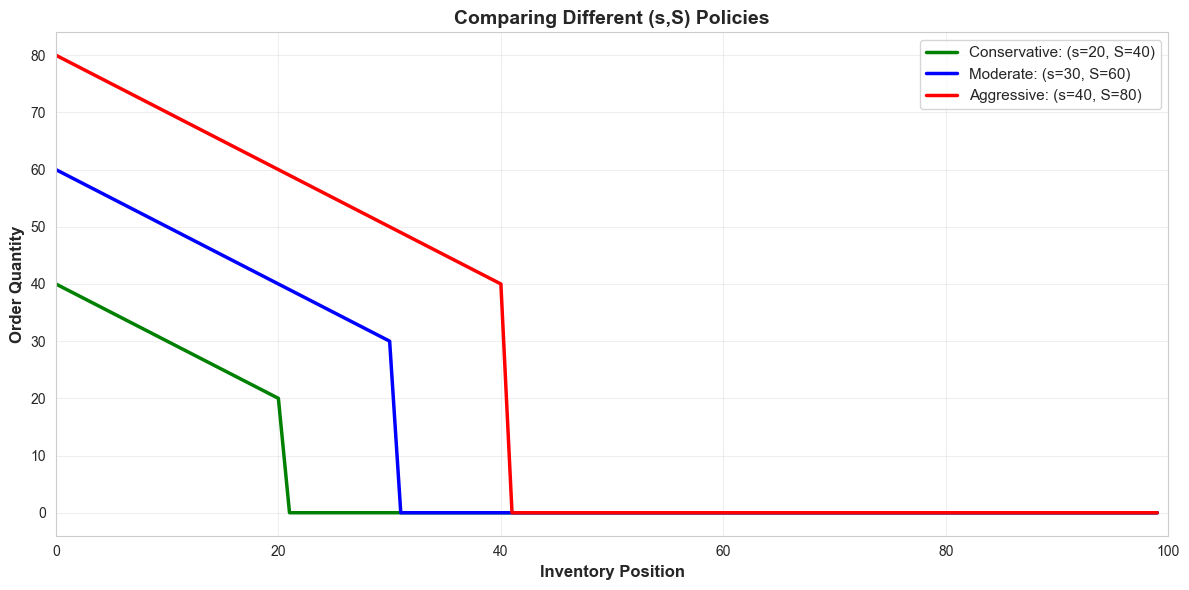


💡 Trade-offs:
   Conservative (low s,S):
     + Less inventory → lower holding cost
     - Higher stockout risk → higher shortage cost

   Aggressive (high s,S):
     + Lower stockout risk
     - More inventory → higher holding cost


In [4]:
# Compare different (s,S) policies
policies = [
    (20, 40, 'Conservative', 'green'),
    (30, 60, 'Moderate', 'blue'),
    (40, 80, 'Aggressive', 'red'),
]

plt.figure(figsize=(12, 6))

for s_val, S_val, label, color in policies:
    positions = np.arange(0, 100, 1)
    orders = [S_val - pos if pos <= s_val else 0 for pos in positions]
    plt.plot(positions, orders, linewidth=2.5, label=f'{label}: (s={s_val}, S={S_val})', color=color)

plt.xlabel('Inventory Position', fontsize=12, fontweight='bold')
plt.ylabel('Order Quantity', fontsize=12, fontweight='bold')
plt.title('Comparing Different (s,S) Policies', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xlim(0, 100)
plt.tight_layout()
plt.show()

print("\n💡 Trade-offs:")
print("   Conservative (low s,S):")
print("     + Less inventory → lower holding cost")
print("     - Higher stockout risk → higher shortage cost")
print("\n   Aggressive (high s,S):")
print("     + Lower stockout risk")
print("     - More inventory → higher holding cost")

## Part 4: Two-Product Extension

For 2 products, we need **4 parameters**:
- (s₀, S₀) for Product 0
- (s₁, S₁) for Product 1

Each product managed independently.

In [5]:
from src.mdp import order_both_products

# Two-product policy
s0, S0 = 30, 60  # Product 0
s1, S1 = 25, 55  # Product 1 (different parameters!)

def sS_policy(obs):
    """(s,S) policy for both products."""
    # Calculate inventory positions
    pos_0 = obs.get_inventory_position(0)
    pos_1 = obs.get_inventory_position(1)
    
    # Apply (s,S) rule for each product
    q0 = max(0, S0 - pos_0) if pos_0 <= s0 else 0
    q1 = max(0, S1 - pos_1) if pos_1 <= s1 else 0
    
    return order_both_products(q0, q1)

# Test
print("Policy Parameters:")
print(f"  Product 0: (s={s0}, S={S0})")
print(f"  Product 1: (s={s1}, S={S1})")

# Test scenario
test_obs = create_observation(
    net_inventory_0=28,
    net_inventory_1=50,
    outstanding_0=0,
    outstanding_1=0
)

action = sS_policy(test_obs)

print("\nTest Scenario:")
print(f"  Net inventory: {test_obs.net_inventory}")
print(f"  Outstanding: {test_obs.outstanding_orders}")
print(f"  Inventory positions: ({test_obs.get_inventory_position(0)}, {test_obs.get_inventory_position(1)})")

print(f"\nPolicy Decision: Order {action.order_quantities}")

print("\nExplanation:")
print(f"  Product 0: IP={test_obs.get_inventory_position(0)} ≤ s={s0}")
print(f"    → Order {action.order_quantities[0]} to reach S={S0}")
print(f"  Product 1: IP={test_obs.get_inventory_position(1)} > s={s1}")
print("    → Don't order")

print("\n💡 Why different parameters?")
print("   Product 1 has higher demand → might need higher s,S")
print("   Product 1 has faster delivery → might tolerate lower s")

Policy Parameters:
  Product 0: (s=30, S=60)
  Product 1: (s=25, S=55)

Test Scenario:
  Net inventory: (28, 50)
  Outstanding: (0, 0)
  Inventory positions: (28, 50)

Policy Decision: Order (32, 0)

Explanation:
  Product 0: IP=28 ≤ s=30
    → Order 32 to reach S=60
  Product 1: IP=50 > s=25
    → Don't order

💡 Why different parameters?
   Product 1 has higher demand → might need higher s,S
   Product 1 has faster delivery → might tolerate lower s


## Part 5: How to Choose (s,S)?

### Rule of Thumb:

**s (reorder point)** ≈ Expected demand during lead time + safety stock

**S (order-up-to)** ≈ s + Economic Order Quantity (EOQ)

In [6]:
from src.simulation import SystemParameters

params = SystemParameters.create_default()

# Calculate expected daily demand
lambda_arrivals = params.lambda_arrival
mean_demand_0 = sum(v*p for v, p in zip(params.demand_0_values, params.demand_0_probs))
mean_demand_1 = sum(v*p for v, p in zip(params.demand_1_values, params.demand_1_probs))

daily_demand_0 = lambda_arrivals * mean_demand_0
daily_demand_1 = lambda_arrivals * mean_demand_1

print("Expected Daily Demand:")
print(f"  Product 0: {daily_demand_0:.3f} units/day")
print(f"  Product 1: {daily_demand_1:.3f} units/day")

# Expected lead time
mean_leadtime_0 = (params.lead_time_0_min + params.lead_time_0_max) / 2
mean_leadtime_1 = (params.lead_time_1_min + params.lead_time_1_max) / 2

print("\nExpected Lead Time:")
print(f"  Product 0: {mean_leadtime_0:.2f} days")
print(f"  Product 1: {mean_leadtime_1:.2f} days")

# Demand during lead time
demand_during_leadtime_0 = daily_demand_0 * mean_leadtime_0
demand_during_leadtime_1 = daily_demand_1 * mean_leadtime_1

print("\nExpected Demand During Lead Time:")
print(f"  Product 0: {demand_during_leadtime_0:.2f} units")
print(f"  Product 1: {demand_during_leadtime_1:.2f} units")

# Suggested parameters
safety_stock = 20  # Buffer for uncertainty
order_size = 30    # Economic order quantity (simplified)

suggested_s0 = int(demand_during_leadtime_0 + safety_stock)
suggested_S0 = suggested_s0 + order_size

suggested_s1 = int(demand_during_leadtime_1 + safety_stock)
suggested_S1 = suggested_s1 + order_size

print("\n💡 Suggested Parameters:")
print(f"  Product 0: (s={suggested_s0}, S={suggested_S0})")
print(f"  Product 1: (s={suggested_s1}, S={suggested_S1})")

print("\nRationale:")
print("  s = demand_during_leadtime + safety_stock")
print("  S = s + order_size")
print("\nNote: These are rough estimates - optimal values require optimization!")

Expected Daily Demand:
  Product 0: 0.250 units/day
  Product 1: 0.363 units/day

Expected Lead Time:
  Product 0: 0.75 days
  Product 1: 0.45 days

Expected Demand During Lead Time:
  Product 0: 0.19 units
  Product 1: 0.16 units

💡 Suggested Parameters:
  Product 0: (s=20, S=50)
  Product 1: (s=20, S=50)

Rationale:
  s = demand_during_leadtime + safety_stock
  S = s + order_size

Note: These are rough estimates - optimal values require optimization!


## 🎯 Summary

**What you learned:**

1. **(s,S) Policy**:
   - If IP ≤ s: order (S - IP) units
   - Otherwise: don't order
   - Simple, provably optimal under certain conditions

2. **Key Concepts**:
   - s = When to order (reorder point)
   - S = Target level (order-up-to)
   - IP = Net_Inventory + Outstanding

3. **Trade-offs**:
   - Low s,S: Less inventory, more stockout risk
   - High s,S: More inventory, less stockout risk
   - Must balance holding vs shortage costs

4. **Two Products**:
   - Independent policies (s₀,S₀) and (s₁,S₁)
   - Can tune parameters separately
   - Different demand/lead times → different parameters

5. **Choosing Parameters**:
   - s ≈ demand during lead time + safety stock
   - S ≈ s + economic order quantity
   - Optimal values require search/optimization

**Next**: Implement and evaluate (s,S) policy!

**Then**: Compare with RL agents to see if they can beat the baseline!